In [1]:
# ====================================================
# Library
# ====================================================

import logging
from time import time
import pickle
from tqdm.notebook import tqdm

from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
import numpy as np
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from scipy.stats import wishart, chi2

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/mknzm/development/new_study/env_tex/01_notebook_module/bayes")

import bayes

In [3]:
# ====================================================
# Load Data
# ====================================================

rng = RandomState(0)
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

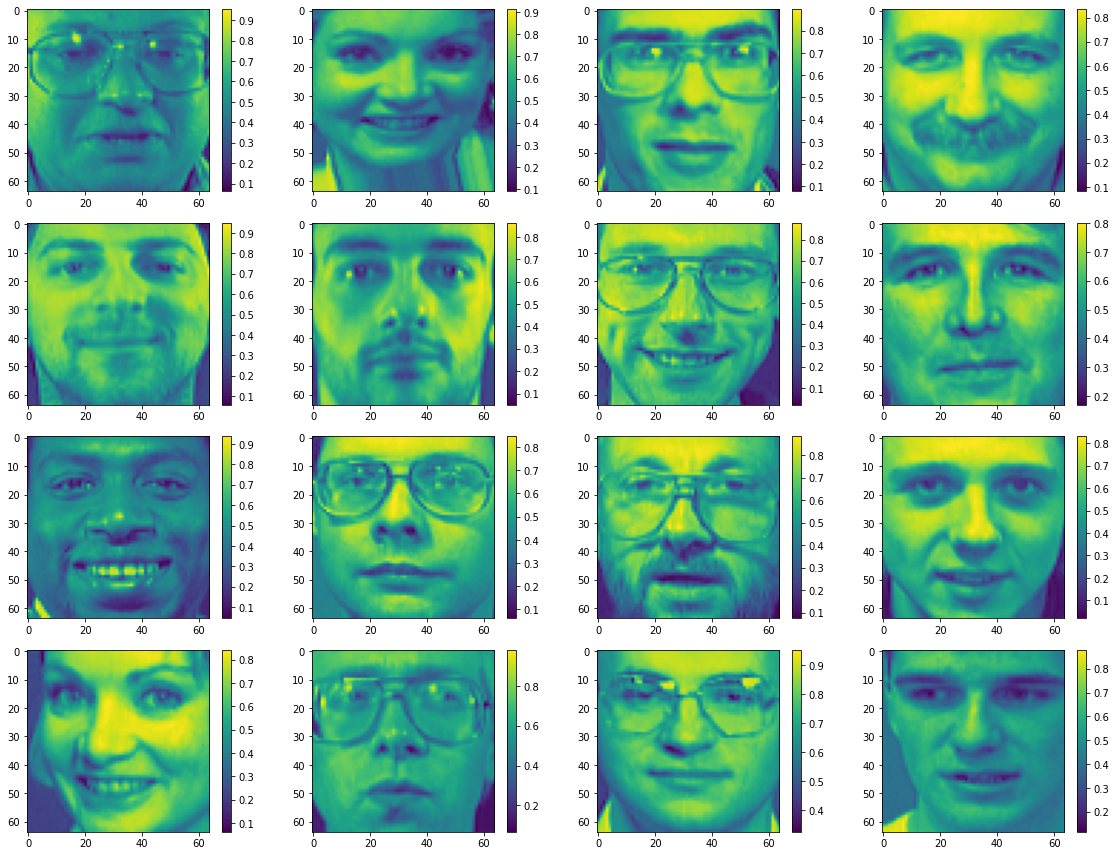

In [4]:
# ====================================================
# Show Data
# ====================================================

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(faces[1+i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

In [5]:
n_features

4096

# 1. Compare m

In [7]:
%%time

# ====================================================
# Prepare Model
# ====================================================

np.random.seed(seed=620)

num_train = 350
train_set = faces[:num_train]
valid_set = faces[num_train:]

u,s,v = np.linalg.svd(train_set)
smat = np.zeros(train_set.shape, dtype=float)
smat[:s.shape[0], :s.shape[0]] = np.diag(s)

for m in [32, 64,128, 256, 512]:
    M = m
    first_x = u[:,:M]
    first_w = np.dot(smat, v)[:M]
    first_mu = np.mean(train_set, axis = 0)
    
    d = faces.shape[1]
    n = num_train

    gold_param = {
        "y": train_set,
        "valid": valid_set,
        "w": bayes.prior.Normal(np.zeros(shape = (m, d)), np.eye(m)),
        "x": bayes.prior.Normal(np.zeros(shape = (num_train, m)), np.eye(m)),
        "mu": bayes.prior.Normal(np.zeros(shape = d), np.eye(d)),
        "sigma": 0.1,
        "w_mean": first_w,
        "w_variance": np.eye(m),
        "x_mean": first_x,
        "x_variance": np.eye(m),
        "mu_mean": first_mu,
        "mu_variance": np.eye(d),
    }
    
    globals()[f"LDR_gold_{M}"] = bayes.model.LDR(**gold_param)
    print(f"M: {M}", end=": ")
    globals()[f"LDR_gold_{M}"].optimize(10)

M: 32: Epoch0: train0.1347, valid0.1854
Epoch1: train0.1347, valid0.1854
Epoch2: train0.1347, valid0.1854
Epoch3: train0.1347, valid0.1854
Epoch4: train0.1346, valid0.1853
Epoch5: train0.1346, valid0.1853
Epoch6: train0.1346, valid0.1853
Epoch7: train0.1346, valid0.1853
Epoch8: train0.1346, valid0.1853
Epoch9: train0.1346, valid0.1853
M: 64: Epoch0: train0.07744, valid0.1369
Epoch1: train0.07743, valid0.1369
Epoch2: train0.07743, valid0.1369
Epoch3: train0.07743, valid0.1369
Epoch4: train0.07742, valid0.1369
Epoch5: train0.07742, valid0.1369
Epoch6: train0.07741, valid0.1369
Epoch7: train0.07741, valid0.1369
Epoch8: train0.07741, valid0.1369
Epoch9: train0.0774, valid0.1369
M: 128: Epoch0: train0.03338, valid0.1016
Epoch1: train0.03338, valid0.1016
Epoch2: train0.03338, valid0.1016
Epoch3: train0.03338, valid0.1016
Epoch4: train0.03338, valid0.1016
Epoch5: train0.03338, valid0.1016
Epoch6: train0.03338, valid0.1016
Epoch7: train0.03338, valid0.1016
Epoch8: train0.03338, valid0.1016
Epo

ValueError: operands could not be broadcast together with shapes (512,512) (350,350) (512,512) 

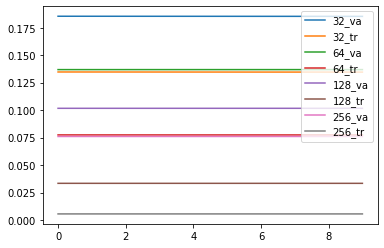

In [10]:
log_va_m = {}
log_tr_m = {}

for M in [32, 64,128, 256]:
    length = globals()[f"LDR_gold_{M}"].log_va.__len__()
    va_log = globals()[f"LDR_gold_{M}"].log_va
    tr_log = globals()[f"LDR_gold_{M}"].log_tr
    log_va_m[M] = va_log[-1]
    log_tr_m[M] = tr_log[-1]
    plt.plot(range(length), va_log, label = f"{M}_va")
    plt.plot(range(length), tr_log , label = f"{M}_tr")

plt.legend(loc='upper right')

plt.show()

In [12]:
display(min(log_va_m, key=log_va_m.get), min(log_va_m.values()))
display(min(log_tr_m, key=log_tr_m.get), min(log_tr_m.values()))

256

0.07600088620014617

256

0.00555252912253776

In [13]:
def display_m(M):
    second_train = globals()[f"LDR_gold_{M}"].predict(faces[1:17])

    n_figure = 16
    n_cols = 4
    n_rows = 4
    fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

    for i, ax in enumerate(np.ravel(axes)):
        im = ax.imshow(second_train[i].reshape(64,64))
        fig.colorbar(im,ax=ax)

    plt.tight_layout()
    plt.show()

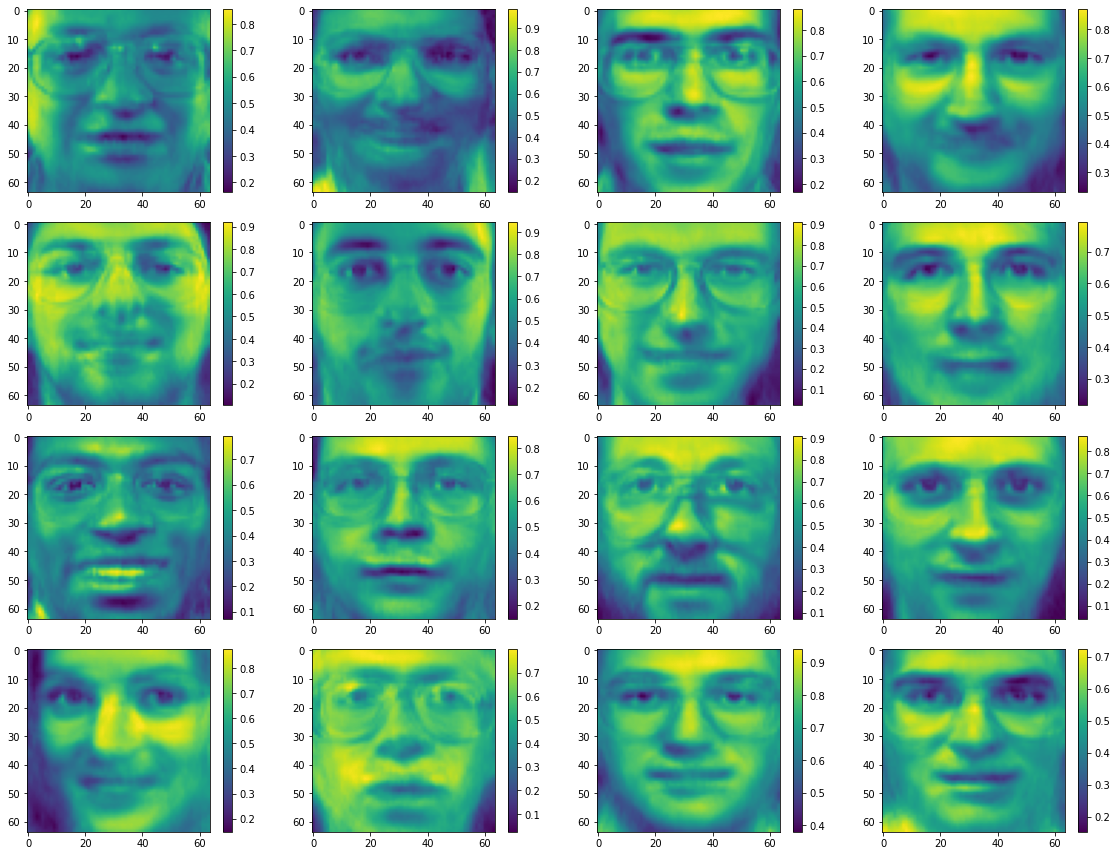

32


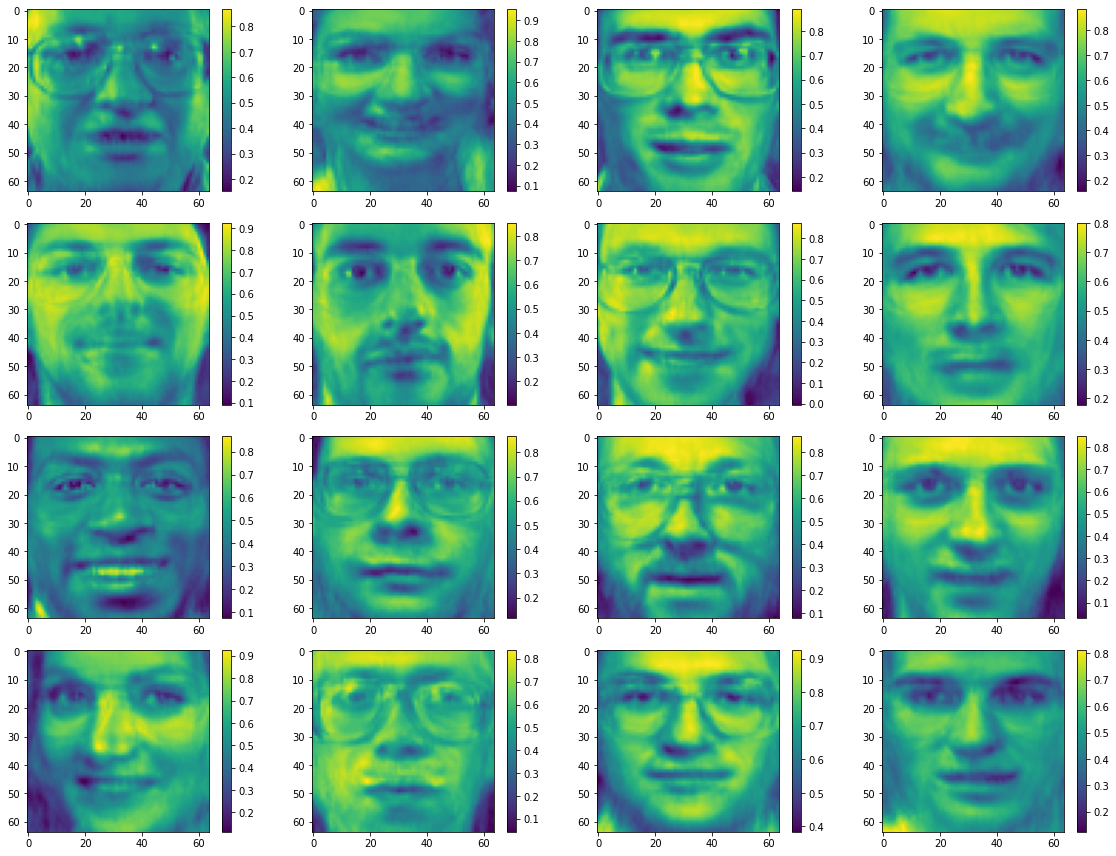

64


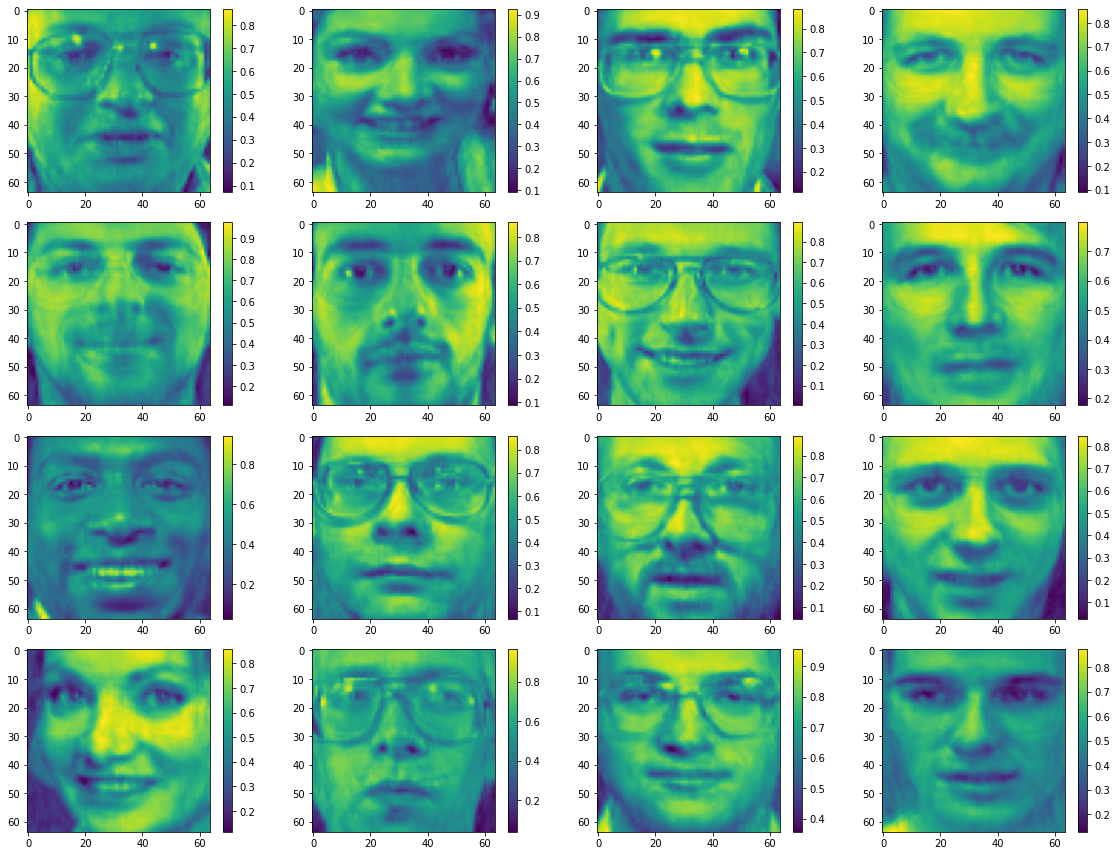

128


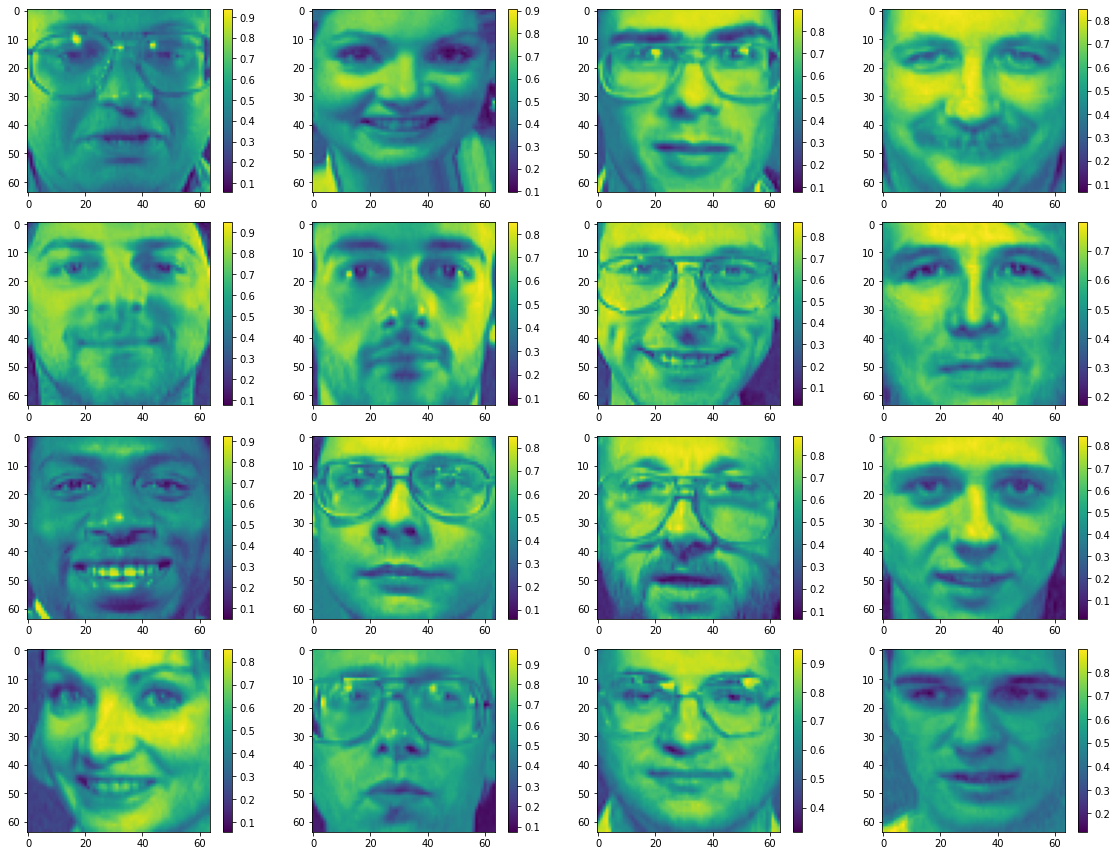

256


In [14]:
for M in [32, 64,128, 256]:
    display_m(M)
    print(M)